# Process Sentinel-1 InSAR pair

In [ ]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt

import geopandas as gpd
from eodag import EODataAccessGateway
import rioxarray as riox

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
logging.basicConfig(level=logging.INFO)

## Set up parameters and output dir

In [3]:
# change to your custom locations
data_dir = "/data/S1"

ids = [
 "S1A_IW_SLC__1SDV_20230904T063730_20230904T063757_050174_0609E3_DAA1", 
 "S1A_IW_SLC__1SDV_20230916T063730_20230916T063757_050349_060FCD_6814"
]
primary_dir = f"{data_dir}/{ids[0]}.zip"
secondary_dir = f"{data_dir}/{ids[1]}.zip"
outputs_prefix="/data/res/test-full-processor"

## Download S-1 products

In [ ]:
# load a geometry
file_aoi = "https://raw.githubusercontent.com/odhondt/eo_tools/refs/heads/main/data/Morocco_AOI.geojson"
shp = gpd.read_file(file_aoi).geometry[0]

search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2023-09-03",
    "end": "2023-09-17",
    "geom": shp
}

results, _ = dag.search(**search_criteria)
to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
dag.download_all(to_dl, outputs_prefix="/data/S1/", extract=False)

## Pre-process InSAR pair

In [ ]:
from eo_tools.S1.process import process_insar

out_dir = process_insar(
    dir_prm=primary_dir,
    dir_sec=secondary_dir,
    outputs_prefix=outputs_prefix,
    aoi_name=None,
    shp=shp,
    pol="vv",
    subswaths=["IW1", "IW2", "IW3"],
    write_coherence=True,
    write_interferogram=True,
    write_primary_amplitude=True,
    write_secondary_amplitude=False,
    apply_fast_esd=True,
    dem_upsampling=1.8,
    dem_force_download=False,
    dem_buffer_arc_sec=40,
    boxcar_coherence=[3, 3],
    filter_ifg=True,
    multilook=[1, 4],
    warp_kernel="bicubic",
    clip_to_shape=True,
)

## Visualize

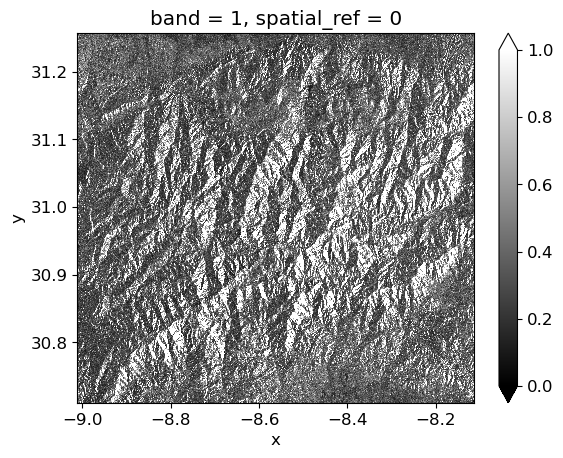

In [6]:
arr_amp = riox.open_rasterio(f"{out_dir}/amp_prm_vv.tif", masked=True)[0]
arr_amp.plot.imshow(vmin=0,vmax=1, cmap="gray")

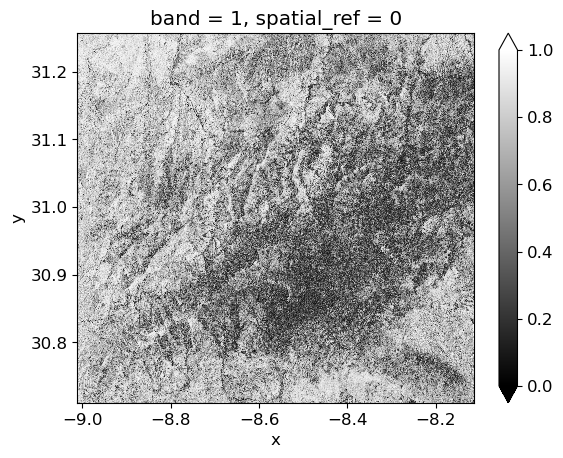

In [7]:
arr_coh = riox.open_rasterio(f"{out_dir}/coh_vv.tif", masked=True)[0]
arr_coh.plot.imshow(vmin=0,vmax=1, cmap="gray")

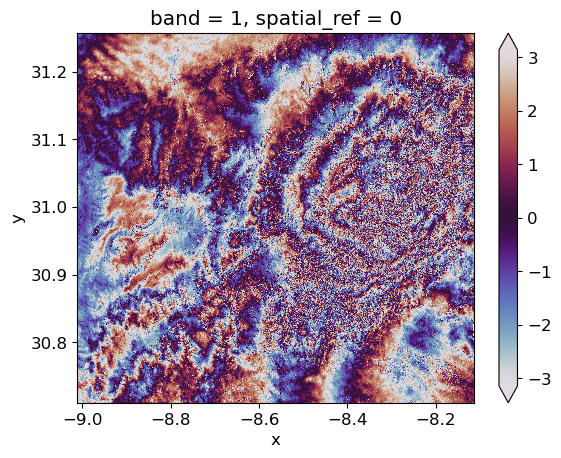

In [8]:
arr_phi = riox.open_rasterio(f"{out_dir}/phi_vv.tif", masked=True)[0]
arr_phi.plot.imshow(vmin=-3.14,vmax=3.14, cmap="twilight")